In [1]:
using Serialization
using ITensors, ITensorMPS, Plots
using ProgressMeter, Statistics, Random, SparseArrays
using JLD2, Printf
include("ldpc_tanner_loops.jl")
include("gallagerBP.jl")
push!(LOAD_PATH, "functions/")
using BP

In [98]:
d_v = 3 
d_c = 4
n = 512
p = 0.17
pbias = p 
max_loop_order = 6
pcmat = gallager_ldpc_matrix(n, d_v, d_c)
tannerloopslist = [find_tanner_loops(pcmat, d; max_length=max_loop_order) for d in 1:n];

In [ ]:
# Sample errors iid with probability p
errors_true = [sample_bit(1-p) for _ in 1:n]
println(sum(errors_true) / n)
err_bits = findall(isodd,errors_true)
# Compute syndrome 
syndrome = pcmat * errors_true .% 2;

0.169921875


In [117]:
# Decode
data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors_loops = Int.(-1 .* ones(n))
errors_no_loops = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages = BP.message_passing(tensors,messages,edges,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true);

In [ ]:
# Decode each data qubit
relativenorm = []
selfconsistencyviolation = []
for d = 1:n 
    probs = get_marginal(vcat(data_tensors, syn_tensors), adj_mat, messages, d)
    vacuum = tensorargmax(probs)
    errors_no_loops[d] = vacuum
    push!(selfconsistencyviolation,BP.check_self_consistency(vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors), messages, adj_mat)[2])
    # Get loops for this data qubit
    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
    check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
    
    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops; exclude=[d]), syn_tensors)
        
        if !isempty(setdiff(data_bits_involved, [d]))
            normlz1 = scalar(prod([get_marginal(mtensors, adj_mat, messages, other_data_bit) 
                                for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        else
            normlz1 = 1.0
        end
        
        if !isempty(check_bits_involved)
            normlz2 = scalar(prod([get_marginal(mtensors, adj_mat, messages, n+check_bit) 
                                for check_bit in check_bits_involved]))
        else
            normlz2 = 1.0
        end
        
        normlz = normlz1 * normlz2
        if normlz != 0
            change = BP.loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
            loopprobs += change 
        end
    end
    push!(relativenorm,norm(loopprobs)/norm(probs))
    loopcorr = tensorargmax(probs + loopprobs)  
    errors_loops[d] = loopcorr

    # Early stopping: if both decoders made errors, no point continuing
    if (errors_no_loops[d] != errors_loops[d])  
        println("loop corr happened")
    end 
end
println("vacuum decoder errors?... ", (sum(e
rrors_no_loops .!= errors_true)/n ))
println("loopcorr decoder errors?... ", (sum(errors_loops .!= errors_true)/n ))
println("self consistency violation per sampled bit...", sum(selfconsistencyviolation)/n)
println("relative loop norm per bit...", sum(relativenorm)/n)

vacuum decoder errors?... 0.12890625
loopcorr decoder errors?... 0.12890625
self consistency violation per sampled bit...1.407645271158323
relative loop norm per bit...0.00016074777788017234


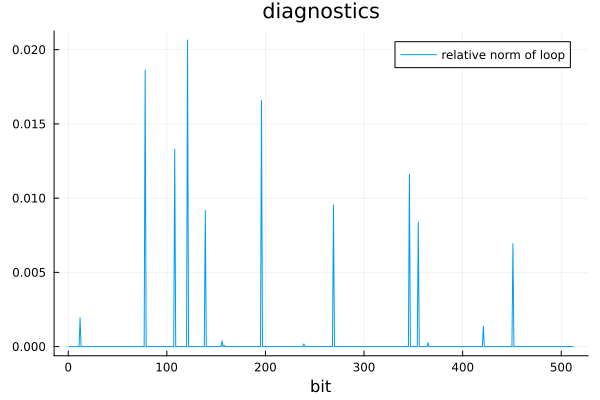

In [104]:
plot(title="diagnostics", xlabel="bit")
plot!(1:n, relativenorm, label="relative norm of loop")


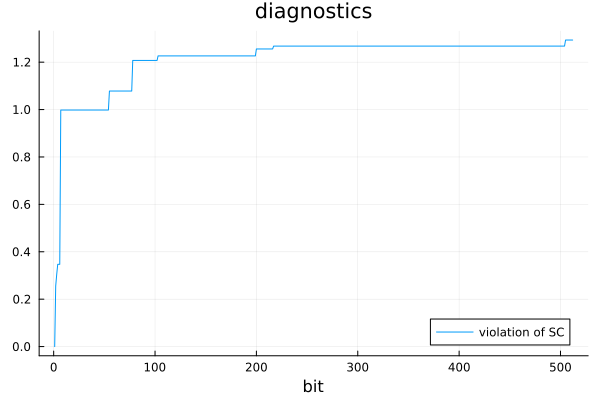

In [105]:
plot(title="diagnostics", xlabel="bit")

plot!(1:n, selfconsistencyviolation, label="violation of SC")